# PCB Defect Segmentation Project 

This notebook contains an experiment to segment the parts with defects on a PCB. The segmentation is done in a one-shot way, where a support image with a similar defect is given with the mask and the segmentation is done on the query image. There are multiple steps in the experiment, they are discussed below. 

In [47]:
# Imports 
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import os
import h5py
import gc
import random

# Set the base directory and device
base_dir = 'data'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### (1) Get DinoV2 tensors from the Train Images

We use [dinov2](https://dinov2.metademolab.com/) model to extract tensors of the images. A large pretraining dataset of 142 million images was assembled and curated from webcrawled data to cover well a number of key visual domains in dinov2 hence these tensors are really good representations of the images and can be used for pixel level matching/semantic segmentation.

In [48]:
# Load the Dinov2 Model
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
model = model.to(device)

Using cache found in /home/vignesh/.cache/torch/hub/facebookresearch_dinov2_main


In [49]:
def list_files(dataset_path):
    """
    This function returns a list of all files in a directory and its subdirectories.
    
    :param dir: The directory path where you want to list all the files
    :return: The function `list_files` returns a list of file paths for all the files in the directory
    and its subdirectories.
    """
    images = []
    for root, _, files in os.walk(dataset_path):
        files.sort()
        print(files)
        for name in files:
            images.append(os.path.join(root, name))
    return images


class CustomImageDataset(Dataset):
    """The above class is a custom dataset class for images in PyTorch."""
    def __init__(self, img_dir, datatype):
        self.img_dir = img_dir
        self.images = list_files(self.img_dir)
        self.datatype = datatype
        random.choices(self.images, k=5)
        self.transform =  transforms.Compose([
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406],
                                                [0.229, 0.224, 0.225])
                        ])
        
        self.transform1 = transforms.Compose([           
                                transforms.Resize(520),
                                transforms.CenterCrop(518), #should be multiple of model patch_size                 
                                transforms.ToTensor(),                    
                                transforms.Normalize(mean=0.5, std=0.2)
                                ])
        self.transform2 = transforms.Compose([           
                                transforms.Resize(520),
                                transforms.CenterCrop(518),
                                transforms.Resize((518//14, 518//14)), #Divide by patch_size
                                transforms.ToTensor(),                                   
                                ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        if(self.datatype == "image"):
            image = self.transform1(image)
        elif(self.datatype == 'mask'):
            image = self.transform2(image)
        return image, img_path

In [50]:
#Load the train Images
dir_path = f"{base_dir}/train/"
dataset = CustomImageDataset(dir_path, 'image')
train_dataloader = DataLoader(dataset, batch_size=1)

['WIN_20221017_18_50_25_Pro_jpg.rf.879494a79c3899c21e9937c6a7d324ac.jpg', 'WIN_20221017_18_58_20_Pro_jpg.rf.3c43e703b0116201b9dd219267d003b0.jpg', 'WIN_20221017_19_25_55_Pro_jpg.rf.d934aaf9fae55abe70df1ddf6e4a5479.jpg', 'WIN_20221017_19_27_29_Pro_jpg.rf.3aa347ea3a7abc00f440556e46238f16.jpg', 'WIN_20221017_19_27_38_Pro_jpg.rf.26da9cf6ed77e3f05fff29c32cf9c8db.jpg', 'WIN_20221017_19_29_10_Pro_jpg.rf.4dc225dd3cd9211c776dac45ae60961f.jpg', 'WIN_20221030_19_11_56_Pro_jpg.rf.659496893238125626ad1b4b5ddb91e0.jpg', 'WIN_20221030_19_34_38_Pro_jpg.rf.58406996d95cb6e950022ba3e01003a1.jpg', 'WIN_20221030_19_36_50_Pro_jpg.rf.d4745be47ca3cf3f8068a363bac6763e.jpg', 'WIN_20221030_19_46_52_Pro_jpg.rf.983c34b97cd28f60df79422ae2c33f45.jpg', 'WIN_20221102_19_16_24_Pro_jpg.rf.81843fac6c88db7a878b8b106ffc5b9d.jpg', 'WIN_20221102_19_30_08_Pro_jpg.rf.2689f4baabba3bcafe3fda40f88ca891.jpg', 'WIN_20221102_19_56_21_Pro_jpg.rf.266bae64c82c5745ee814427729385af.jpg', 'WIN_20221102_20_01_40_Pro_jpg.rf.d0687bdf851809b6

In [51]:
#Extract the tensors using the model on the loaded data

final_img_features = []
final_img_filepaths = []
patch_img_features = []
with torch.no_grad():
    model.eval()
    for image_tensors, file_paths in tqdm(train_dataloader):
        try:
            torch.cuda.empty_cache()
            gc.collect()
            image_features = model(image_tensors.to(device)) #384 small, #768 base, #1024 large
            feats = model.forward_features(image_tensors.to(device))
            patch_feats = feats['x_norm_patchtokens']
            image_features = feats['x_norm_clstoken']
            # print(image_features)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            image_features = image_features.tolist()
            final_img_features.extend(image_features)
            final_img_filepaths.extend((list(file_paths)))
            patch_img_features.extend(patch_feats.tolist())
        except Exception as e:
            print("Exception occurred: ",e)
            break

100%|██████████| 31/31 [01:26<00:00,  2.80s/it]


In [52]:
#Store the extracted features into h5 file  
with h5py.File(f'{base_dir}/features/train_image_features_dino_large.h5','w') as h5f:
    h5f.create_dataset("image_features", data= np.array(final_img_features))
    # to save file names strings in byte format.
    h5f.create_dataset("image_filenames", data= np.array(final_img_filepaths,
                                                             dtype=object))
    h5f.create_dataset("image_patch_features", data=np.array(patch_img_features), dtype=np.float32)

In [53]:
features_file_path = f"{base_dir}/features/train_image_features_dino_large.h5"
print(f"The Features File size:", round(os.path.getsize(features_file_path)/1000000,2),"MB \n")

# Open the HDF5 file for reading
with h5py.File(features_file_path, 'r') as h5f:
    # Read the dataset named "gt_features"
    train_features = np.array(h5f['image_features'])
    # Read the dataset named "jewellery_names"
    train_filenames = np.array(h5f['image_filenames'])
    train_patches = np.array(h5f["image_patch_features"])
    print(h5f.keys())


# Print the shape of the arrays to verify the data
print("Train features shape:", type(train_features), train_features.shape)
print("Images shape:", train_filenames.shape, type(train_filenames))
print("Sample:", random.choices(train_filenames,k = 5))
train_patches.shape

The Features File size: 174.09 MB 

<KeysViewHDF5 ['image_features', 'image_filenames', 'image_patch_features']>
Train features shape: <class 'numpy.ndarray'> (31, 1024)
Images shape: (31,) <class 'numpy.ndarray'>
Sample: [b'data/train/WIN_20221102_20_01_40_Pro_jpg.rf.d0687bdf851809b668cb03efd8ca9717.jpg', b'data/train/WIN_20221103_21_11_51_Pro_jpg.rf.7cc3ff6d700c985183a71affc285a837.jpg', b'data/train/WIN_20221103_21_11_11_Pro_jpg.rf.444a283a012da805d26a8ca8c3d217f5.jpg', b'data/train/WIN_20221030_19_34_38_Pro_jpg.rf.58406996d95cb6e950022ba3e01003a1.jpg', b'data/train/WIN_20221103_21_53_35_Pro_jpg.rf.f7aa0230cfd434ee6f62b3de7e4a528a.jpg']


(31, 1369, 1024)

In [54]:
#Load the mask images
dir_path = f"{base_dir}/train_masks/"
mask_dataset = CustomImageDataset(dir_path, 'mask')
mask_dataloader = DataLoader(mask_dataset, batch_size=1)
mask_tensors = []
mask_filenames = []
for image_tensors, file_paths in tqdm(mask_dataloader):
    mask_tensors.extend(image_tensors)
    mask_filenames.extend(file_paths)

['WIN_20221017_18_50_25_Pro_jpg.rf.879494a79c3899c21e9937c6a7d324ac.jpg', 'WIN_20221017_18_58_20_Pro_jpg.rf.3c43e703b0116201b9dd219267d003b0.jpg', 'WIN_20221017_19_25_55_Pro_jpg.rf.d934aaf9fae55abe70df1ddf6e4a5479.jpg', 'WIN_20221017_19_27_29_Pro_jpg.rf.3aa347ea3a7abc00f440556e46238f16.jpg', 'WIN_20221017_19_27_38_Pro_jpg.rf.26da9cf6ed77e3f05fff29c32cf9c8db.jpg', 'WIN_20221017_19_29_10_Pro_jpg.rf.4dc225dd3cd9211c776dac45ae60961f.jpg', 'WIN_20221030_19_11_56_Pro_jpg.rf.659496893238125626ad1b4b5ddb91e0.jpg', 'WIN_20221030_19_34_38_Pro_jpg.rf.58406996d95cb6e950022ba3e01003a1.jpg', 'WIN_20221030_19_36_50_Pro_jpg.rf.d4745be47ca3cf3f8068a363bac6763e.jpg', 'WIN_20221030_19_46_52_Pro_jpg.rf.983c34b97cd28f60df79422ae2c33f45.jpg', 'WIN_20221102_19_16_24_Pro_jpg.rf.81843fac6c88db7a878b8b106ffc5b9d.jpg', 'WIN_20221102_19_30_08_Pro_jpg.rf.2689f4baabba3bcafe3fda40f88ca891.jpg', 'WIN_20221102_19_56_21_Pro_jpg.rf.266bae64c82c5745ee814427729385af.jpg', 'WIN_20221102_20_01_40_Pro_jpg.rf.d0687bdf851809b6

100%|██████████| 31/31 [00:00<00:00, 227.64it/s]


### (2) Patch Matching ###

We try to do the segmentation one-shot. We select random query and support images. We try to use the ground truth mask of the support image and try to find the points of interest/ points of defect. Then we patch match these points to the query image and try to find the points of interest/ points of defect in the query image.  

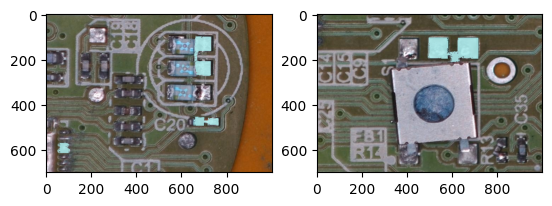

In [55]:
import random
# q_idx = random.choice(range(0, 31))
# im_idx = random.choice(range(0, 31))
# (3, 4) (21, 23) (21, 22) (18, 22)
q_idx = 7
im_idx = 8
colors = {'red': (255, 50, 50), 'blue': (102, 140, 255)}

def apply_mask(image, mask, color, alpha=0.9):
    r""" This function applies the given mask to the given image with a selected color. """
    for c in range(3):
        image[:, :, c] = np.where(mask == 4,
                                    image[:, :, c] *
                                    (1 - alpha) + alpha * color[c] * 255,
                                    image[:, :, c])
    return image

def plot_masked_img(img_path, mask_path, i):
  img = np.array(Image.open(img_path).convert('RGB').resize((1000, 700)))
  mask = np.array(Image.open(mask_path).resize((1000, 700)))
  masked_image = apply_mask(img, mask, colors['red'])
  plt.subplot(1, 2, i+1)
  plt.imshow(masked_image)

plot_masked_img(train_filenames[q_idx], mask_filenames[q_idx], 0)
plot_masked_img(train_filenames[im_idx], mask_filenames[im_idx], 1)

plt.show()

In [56]:
# Extract the points of error in support image using the support mask
def get_scaled_clicks(idx):
    mask = mask_tensors[idx].permute(1, 2, 0)
    data = np.array(mask)
    
    data_min = data.min()

    data_max = data.max()
    data_scaled = (data - data_min) / (data_max - data_min)
    
    max_indices = []
    for row_idx, rows in enumerate(data_scaled):
        for cell_idx, cell in enumerate(rows):
            if cell[0] >= 0.9:
                max_indices.append((row_idx, cell_idx))
                 
    max_indices = np.array(max_indices).T
    # max_indices = np.unravel_index(data_scaled.argmax(), data_scaled.shape)
    
    plt.imshow(data_scaled)
    plt.scatter(max_indices[1], max_indices[0])

    return max_indices

array([[ 6,  6,  7,  7, 11, 11, 12, 12, 13, 13, 25, 25, 25],
       [27, 28, 27, 28, 27, 28, 27, 28, 27, 28, 26, 27, 30]])

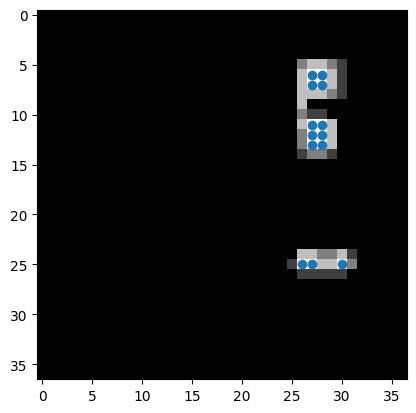

In [57]:
get_scaled_clicks(q_idx)

[[ 6  6  7  7 11 11 12 12 13 13 25 25 25]
 [27 28 27 28 27 28 27 28 27 28 26 27 30]]


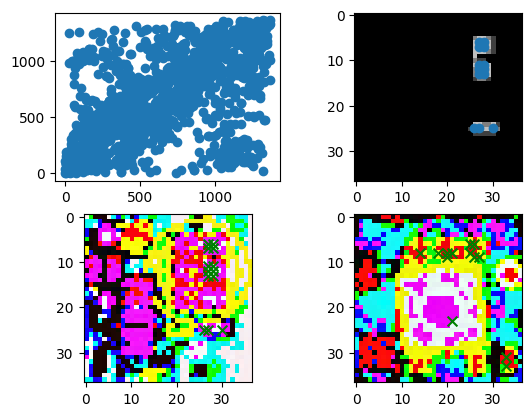

In [58]:
#Try to find the points in query that are similar to points of error in support and visualize them using PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

patch_size = model.patch_size # patchsize=14

Ph  = 520//patch_size
Pw  = 520//patch_size
F = 1024

def scaled_click_to_flattened_index(sc, Ph, Pw):
  dummy = np.zeros((Ph, Pw))
  row, col = sc
  dummy[row, col] = 1
  dummy = dummy.flatten()
  return np.where(dummy)

def flattened_index_to_scaled_click(find, Ph, Pw):
  dummy = np.zeros((Ph, Pw))
  dummy = dummy.flatten()
  dummy[find] = 1
  dummy = dummy.reshape((Ph, Pw))
  return np.where(dummy)

def normfunc(rgbfeat):
  normalized_image = rgbfeat / 255.0
  normalized_image = (normalized_image * 255).astype(np.uint8) 
  return normalized_image

from scipy.optimize import linear_sum_assignment
queryfeats = train_patches[q_idx]  
feat = train_patches[im_idx] 
dsim = torch.zeros(Ph*Pw, Ph*Pw)
vectorfeat = feat.reshape(Ph*Pw, F)
for qind, queryfeat in enumerate(queryfeats.reshape(Ph*Pw, F)):
  print(f"{qind}/{Ph*Pw}", end='\r')
  dsim[qind] = torch.from_numpy((queryfeat.reshape(1, F) - vectorfeat)).norm(dim=1)

row_ind, col_ind = linear_sum_assignment(dsim)

plt.figure()
plt.subplot(2,2,1) 
plt.scatter(row_ind, col_ind)

plt.subplot(2,2,2) 
scaled_clicks = get_scaled_clicks(q_idx)
# scaled_clicks = [[row // 14 for row in scaled_clicks[0]], [col // 14 for col in scaled_clicks[1]]]
print(scaled_clicks)

plt.subplot(2,2,3) 
rgbquery = PCA(3).fit_transform(queryfeats.reshape(Ph*Pw, F)).reshape(Ph, Pw, 3)
plt.imshow(normfunc(rgbquery))

sc = scaled_clicks
plt.scatter(sc[1],  sc[0], marker='x', s=50, c='g')

plt.subplot(2,2,4)
rgbfeat = PCA(3).fit_transform(vectorfeat).reshape(Ph, Pw, 3)
plt.imshow(normfunc(rgbfeat))

sc = scaled_clicks
sc_mapping_row = scaled_click_to_flattened_index(sc, Ph, Pw)
mapped_col = col_ind[sc_mapping_row]
mapped_sc = flattened_index_to_scaled_click(mapped_col, Ph, Pw)
plt.scatter(mapped_sc[1],  mapped_sc[0], marker='x', s=50, c='g')


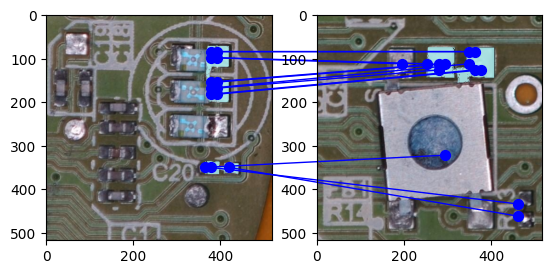

In [59]:
# Make the plots to show patch matching between support and query images
from matplotlib.patches import ConnectionPatch

transform = transforms.Compose([           
                            transforms.Resize(520),
                            transforms.CenterCrop(518)
                            ])

def plot_points_img(img_path, mask_path,i, sc):
    img = np.array(transform(Image.open(img_path).convert('RGB')))
    mask = np.array(transform(Image.open(mask_path)))
    masked_image = apply_mask(img, mask, colors['red'])
    plt.subplot(1, 2, i+1)
    # new_sc = [sc[0] * 14, sc[1] * 14]
    new_sc = [[row * 14 for row in sc[0]], [col * 14 for col in sc[1]]]
    
    plt.scatter(new_sc[1],  new_sc[0], s=50, c='b')
    plt.imshow(masked_image)
    return new_sc

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
new_sc1 = plot_points_img(train_filenames[q_idx], mask_filenames[q_idx], 0, sc.copy())
new_sc2 = plot_points_img(train_filenames[im_idx], mask_filenames[im_idx], 1, mapped_sc)
for i in range(len(new_sc1[0])):
    xyA = [new_sc1[1][i], new_sc1[0][i]]
    xyB = [new_sc2[1][i], new_sc2[0][i]]
    con1 = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA="data", coordsB="data", axesA=ax1, axesB=ax2, color="blue")
    ax2.add_artist(con1)

plt.show()    

### (3) Region Growing ###

We now try to find the seed points from the extracted points of error in query by removing the outliers. Then we perform region growing from these seed points in order to get a segmented mask. We use DBSCAN clustering in order to elimate the outliers. DBSCAN makes clusters based on density of points, hence this would be helpful in our case.

[[ 84 350]
 [ 84 364]
 [112 196]
 [112 252]
 [112 280]
 [112 294]
 [112 350]
 [126 280]
 [126 364]
 [126 378]
 [322 294]
 [434 462]
 [462 462]]
{0, 1, 2, -1}


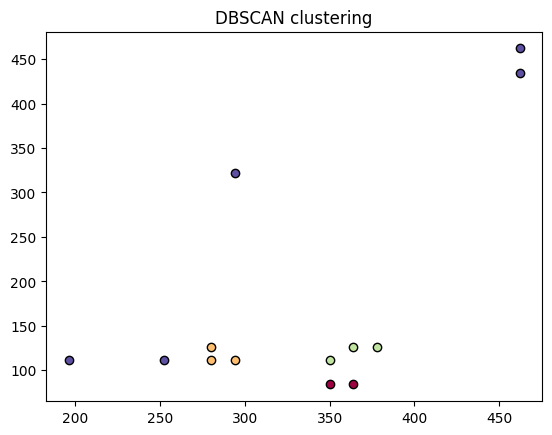

In [60]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

points = np.array(new_sc2)

# Transpose the points to have one coordinate per row
points = points.transpose()
print(points)

# Apply DBSCAN
dbscan = DBSCAN(eps=25, min_samples=2)
labels = dbscan.fit_predict(points)
# Plot the clusters
unique_labels = set(labels)
print(unique_labels)
colors_2 = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors_2):
    class_member_mask = (labels == k)
    xy = points[class_member_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title('DBSCAN clustering')
plt.show()

{0, 1, 2, -1}
{0, 1, 2, -1}
[[84, 84, 98, 98, 154, 154, 168, 168, 182, 182, 350, 350, 350], [378, 392, 378, 392, 378, 392, 378, 392, 378, 392, 364, 378, 420]] [[385. 385. 371.]
 [ 91. 168. 350.]] [[357.         284.66666667 364.        ]
 [ 84.         116.66666667 121.33333333]]


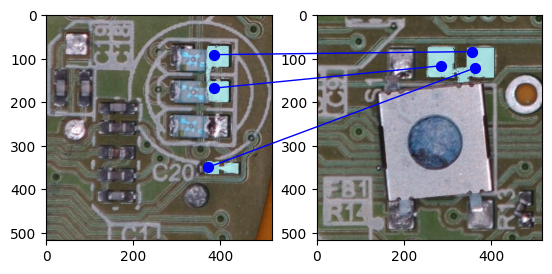

In [61]:
#Visualize the centers obtained after DBSCAN clustering

from matplotlib.patches import ConnectionPatch
import math
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

transform = transforms.Compose([           
                            transforms.Resize(520),
                            transforms.CenterCrop(518)
                            ])
def get_DBSCAN_centers(xy):
    points = np.array(xy)
    points = points.transpose()
    # Apply DBSCAN
    dbscan = DBSCAN(eps=25, min_samples=2)
    labels = dbscan.fit_predict(points)
    unique_labels = set(labels)
    print(unique_labels)
    cluster_centers = []
    all_cluster_points = []

    for k in unique_labels:
        if k == -1:
            continue
        class_member_mask = (labels == k)
        cluster_points = points[class_member_mask]
        x = cluster_points[:, 1]
        y = cluster_points[:, 0]
        cluster_center = [np.mean(x), np.mean(y)]
        all_cluster_points.append([x, y])
        # cluster_center = np.mean(cluster_points, axis=0)
        cluster_centers.append(cluster_center)
    
    return cluster_centers, all_cluster_points

def plot_points_img(img_path, mask_path,i, sc):
    img = np.array(transform(Image.open(img_path).convert('RGB')))
    mask = np.array(transform(Image.open(mask_path)))
    masked_image = apply_mask(img, mask, colors['red'])
    plt.subplot(1, 2, i+1)    
    plt.scatter(sc[0],  sc[1], s=50, c='b')
    plt.imshow(masked_image)
    return masked_image

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
centersT, _ = get_DBSCAN_centers(new_sc1)
centers_2T, all_cluster_points = get_DBSCAN_centers(new_sc2)
centers = np.transpose(centersT)
centers_2 = np.transpose(centers_2T)
plot_points_img(train_filenames[q_idx], mask_filenames[q_idx], 0, centers)
plot_points_img(train_filenames[im_idx], mask_filenames[im_idx], 1, centers_2)

print(new_sc1, centers, centers_2)
for i in range(min(len(centers[0]), len(centers_2[0]))):
    xyA = [centers[0][i], centers[1][i]]
    xyB = [centers_2[0][i], centers_2[1][i]]
    con1 = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA="data", coordsB="data", axesA=ax1, axesB=ax2, color="blue")
    ax2.add_artist(con1)

plt.show()    

[[84, 350], [84, 364], [112, 280], [112, 294], [126, 280], [112, 350], [126, 364], [126, 378]]


/tmp/ipykernel_461652/3330242370.py:25: RuntimeWarning: overflow encountered in scalar subtract
  intensity_difference = np.abs(seed_intensity - current_intensity)


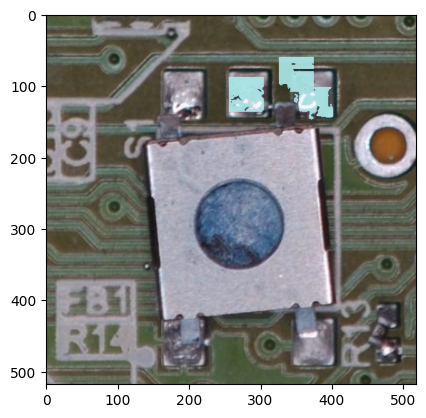

In [62]:
#Region Growing Based on Intensity/ Gradients
import cv2
def region_grow(image, seeds, threshold):
    rows, cols = image.shape
    visited = np.zeros_like(image)
    region = []

    gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    
    for seed in seeds:
        stack = [seed]

        seed_intensity = image[seed[0], seed[1]]
        seed_gradient = gradient_magnitude[seed[0], seed[1]]

        while len(stack) != 0:
            current_point = stack.pop()
            x, y = current_point

            if seed[0]-25 < x < seed[0]+25 and seed[1]-25 < y < seed[1]+25 and not visited[x, y]:
                current_intensity = image[x, y]
                current_gradient = gradient_magnitude[x, y]
                intensity_difference = np.abs(seed_intensity - current_intensity)

                if intensity_difference < threshold:
                    visited[x, y] = 1
                    region.append(current_point)

                    # Add neighboring pixels
                    for i in range(x - 1, x + 2):
                        for j in range(y - 1, y + 2):
                            if 0 <= i < rows and 0 <= j < cols and not visited[i, j]:
                                stack.append((i, j))

    return region


image = np.array(transform(Image.open(train_filenames[im_idx]).convert('L')), dtype=np.uint8)
seed_point = []
# seed_point = [[int(centers_2[1][0]), int(centers_2[0][0])]]

for cluster in all_cluster_points:
    for x, y in np.transpose(cluster):
        seed_point.append([int(y), int(x)])
print(seed_point)
intensity_threshold = 120

result_region = region_grow(image, seed_point, intensity_threshold)
output_mask = np.zeros(image.shape)
for point in result_region:
    output_mask[point[0], point[1]] = 4  # Set the pixel value to white

#Visualize the mask obtained through Region Growing
image_rgb = np.array(transform(Image.open(train_filenames[im_idx]).convert('RGB')))
plt.imshow(apply_mask(image_rgb, output_mask, colors['red']))
plt.show()

In [63]:
#Function to calculate IOU Score
def calculate_iou(gt_mask, pred_mask):
  tp = 0
  fp = 0
  fn = 0

  for i in range(gt_mask.shape[0]):
    for j in range(gt_mask.shape[1]):
      if gt_mask[i][j] == 4 and pred_mask[i][j] == 4:
        tp += 1
      elif gt_mask[i][j] == 0 and pred_mask[i][j] == 4:
        fp += 1
      elif gt_mask[i][j] == 4 and pred_mask[i][j] == 0:
        fn += 1

  iou = tp / (tp + fp + fn)

  return iou

In [64]:
gt_mask = np.array(transform(Image.open(mask_filenames[im_idx])))
calculate_iou(gt_mask, output_mask)

0.41489464062349657